In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from sklearn.utils.multiclass import unique_labels
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[9]')

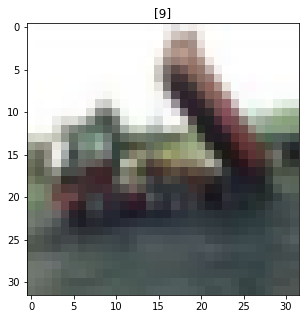

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(x_train[2])
plt.title(y_train[2])

In [4]:
x_train = tf.keras.applications.vgg16.preprocess_input(x_train.astype(np.float32))
x_test = tf.keras.applications.vgg16.preprocess_input(x_test.astype(np.float32))

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [5]:
x_train,x_val, y_train,y_val = train_test_split(x_train, y_train, test_size=.2, shuffle=True)

In [6]:
# Lets print the dimensions one more time to see if things changed the way we expected
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000, 10))
((10000, 32, 32, 3), (10000, 10))
((10000, 32, 32, 3), (10000, 10))


In [9]:
'The first base model used is VGG16. The pretrained weights from the imagenet challenge are used'
base_model_1 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=y_train.shape[1])

58900480/58889256 [==============================] - 1s 0us/step


In [10]:
trainable_weights = 0
for var in base_model_1.trainable_weights:
    trainable_weights += var.numpy().size
print(f'The trainable weights = {trainable_weights} and the number of layers = {len(base_model_1.layers)}')

The trainable weights = 14714688 and the number of layers = 19


In [11]:
# create the base pre-trained model
base_model = base_model_1

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_1 = Model(inputs=base_model.input, outputs=predictions)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [53]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [12]:
batch_size = 64
epochs = 20
learn_rate= 1e-3
adam = tf.keras.optimizers.Adam(learning_rate=learn_rate)

In [13]:
model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

In [15]:
h1 = model_1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                steps_per_epoch=x_train.shape[0]//batch_size,
                validation_data=(x_val,y_val),
                callbacks=[early_stop],
                verbose=1)

Epoch 1/20
625/625 [==============================] - 65s 87ms/step - loss: 2.0245 - accuracy: 0.2168 - val_loss: 1.7975 - val_accuracy: 0.2882
Epoch 2/20
625/625 [==============================] - 53s 85ms/step - loss: 1.7009 - accuracy: 0.3239 - val_loss: 1.5043 - val_accuracy: 0.4030
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 1.3175 - accuracy: 0.5068 - val_loss: 1.1049 - val_accuracy: 0.5976
Epoch 4/20
625/625 [==============================] - 53s 85ms/step - loss: 1.0391 - accuracy: 0.6294 - val_loss: 0.9639 - val_accuracy: 0.6713
Epoch 5/20
625/625 [==============================] - 55s 87ms/step - loss: 0.8784 - accuracy: 0.6929 - val_loss: 1.0818 - val_accuracy: 0.6541
Epoch 6/20
625/625 [==============================] - 53s 85ms/step - loss: 0.7887 - accuracy: 0.7293 - val_loss: 0.8325 - val_accuracy: 0.7175
Epoch 7/20
625/625 [==============================] - 53s 85ms/step - loss: 0.6978 - accuracy: 0.7653 - val_loss: 0.7894 - val_accuracy:

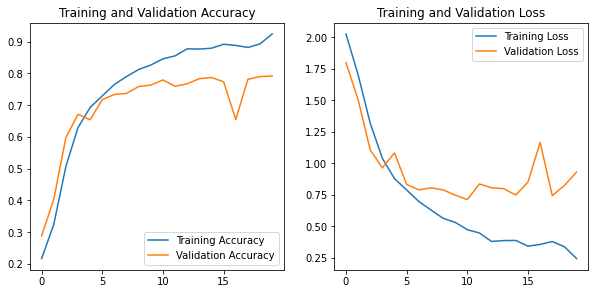

In [16]:
epochs_range = range(20)

acc = h1.history['accuracy']
val_acc = h1.history['val_accuracy']
loss = h1.history['loss']
val_loss = h1.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from vgg16. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)
model_1.summary()

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 1

In [19]:
# we chose to train the top 2 vgg16 blocks, i.e. we will freeze
# the first 17 layers and unfreeze the rest:
for layer in model_1.layers[:17]:
   layer.trainable = False
for layer in model_1.layers[17:]:
   layer.trainable = True
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [21]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
h1_2 = model_1.fit(x_train,y_train,
            batch_size=batch_size,
            epochs=20,
            steps_per_epoch=x_train.shape[0]//batch_size,
            validation_data=(x_val,y_val),
            callbacks=[early_stop],
            verbose=1)

Epoch 1/20
625/625 [==============================] - 23s 36ms/step - loss: 0.1673 - accuracy: 0.9502 - val_loss: 0.8937 - val_accuracy: 0.7972
Epoch 2/20
625/625 [==============================] - 22s 35ms/step - loss: 0.1570 - accuracy: 0.9511 - val_loss: 0.8898 - val_accuracy: 0.7979
Epoch 3/20
625/625 [==============================] - 23s 38ms/step - loss: 0.1538 - accuracy: 0.9515 - val_loss: 0.8808 - val_accuracy: 0.7980
Epoch 4/20
625/625 [==============================] - 23s 36ms/step - loss: 0.1521 - accuracy: 0.9518 - val_loss: 0.8927 - val_accuracy: 0.7987
Epoch 5/20
625/625 [==============================] - 22s 35ms/step - loss: 0.1510 - accuracy: 0.9523 - val_loss: 0.8986 - val_accuracy: 0.7983
Epoch 6/20
625/625 [==============================] - 22s 35ms/step - loss: 0.1498 - accuracy: 0.9520 - val_loss: 0.8971 - val_accuracy: 0.7974
Epoch 7/20
625/625 [==============================] - 23s 37ms/step - loss: 0.1489 - accuracy: 0.9524 - val_loss: 0.9057 - val_accuracy:

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [25]:
y_pred = model_1.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true,y_pred)

In [26]:
y_pred

array([3, 8, 8, ..., 5, 1, 7])

In [27]:
y_true

array([3, 8, 8, ..., 5, 1, 7])

In [28]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


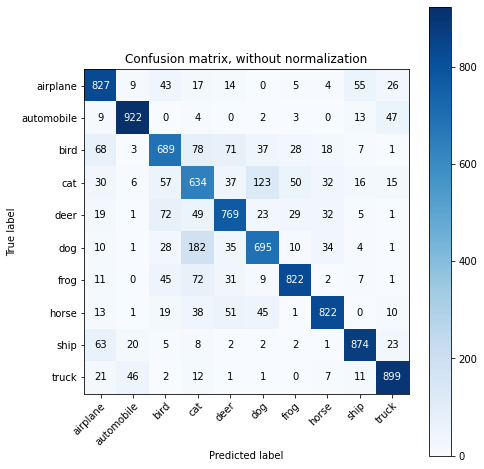

In [29]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


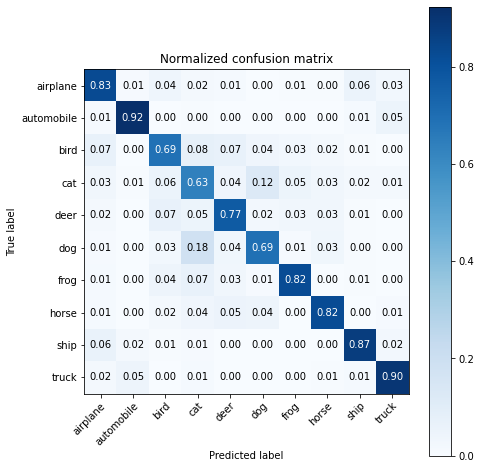

In [30]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()

# Use better network

In [3]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 7s 0us/step


In [4]:
# This method has the preprocess to train a model
def preprocess_data(X, Y):
# applying astype to change float64 to float32 for version 1.12
    X = X.astype('float32')
#using preprocess VGG16 method by default to scale images and their values
    X_p = tf.keras.applications.vgg16.preprocess_input(X)
# changind labels to one-hot representation
    Y_p = tf.keras.utils.to_categorical(Y, 10)
    return (X_p, Y_p)

def decay(epoch):
# This method create the alpha
# returning a very small constant learning rate
    return 0.001 / (1 + 1 * 30)

In [5]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [6]:
x_train,x_val, y_train,y_val = train_test_split(x_train, y_train, test_size=.2, shuffle=True)

In [7]:
# Lets print the dimensions one more time to see if things changed the way we expected
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000, 10))
((10000, 32, 32, 3), (10000, 10))
((10000, 32, 32, 3), (10000, 10))


In [8]:
base_model_2 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', pooling='avg')

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
model= tf.keras.Sequential()
# using upsamplign to get more data points and improve the predictions
model.add(tf.keras.layers.UpSampling2D())
model.add(base_model_2)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation=('relu')))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation=('relu')))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation=('softmax')))

In [10]:
# adding callbacks
callback = []
callback += [tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)]
callback += [tf.keras.callbacks.ModelCheckpoint('cifar10.h5', save_best_only=True, mode='min')]
# tensorboard callback
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#callback += [K.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]

# Compiling model with adam optimizer and looking the accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# training model with mini batch using shuffle data
h16 = model.fit(x=x_train, y=y_train,
                batch_size=128,
                validation_data=(x_val, y_val),
                epochs=20,
                shuffle=True,
                callbacks=[callback],
                verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 3.2258064516129034e-05.
Epoch 1/20
313/313 [==============================] - 122s 345ms/step - loss: 1.4757 - accuracy: 0.4985 - val_loss: 0.6573 - val_accuracy: 0.7828 - lr: 3.2258e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.2258064516129034e-05.
Epoch 2/20
313/313 [==============================] - 105s 335ms/step - loss: 0.5967 - accuracy: 0.8044 - val_loss: 0.4460 - val_accuracy: 0.8535 - lr: 3.2258e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.2258064516129034e-05.
Epoch 3/20
313/313 [==============================] - 105s 335ms/step - loss: 0.3871 - accuracy: 0.8716 - val_loss: 0.4109 - val_accuracy: 0.8688 - lr: 3.2258e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.2258064516129034e-05.
Epoch 4/20
313/313 [==============================] - 105s 335ms/step - loss: 0.2705 - accuracy: 0.9105 - val_loss: 0.3458 - val_accuracy: 0.8889 - lr: 3.2258e-05

Epoch 5: LearningRateSc

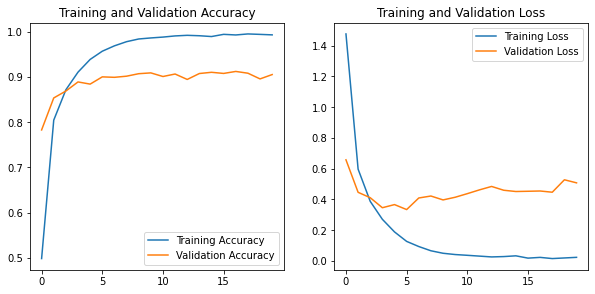

In [13]:
epochs_range = range(20)

acc = h16.history['accuracy']
val_acc = h16.history['val_accuracy']
loss = h16.history['loss']
val_loss = h16.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true,y_pred)

In [15]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


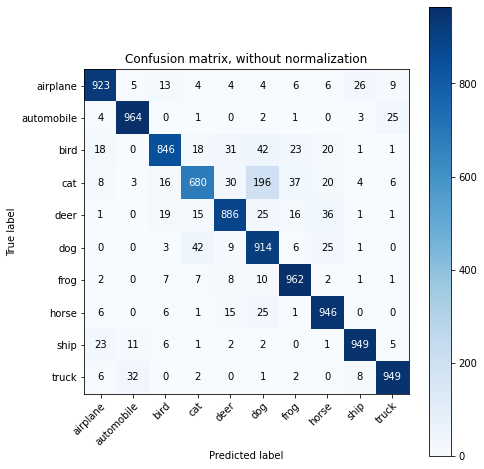

In [16]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


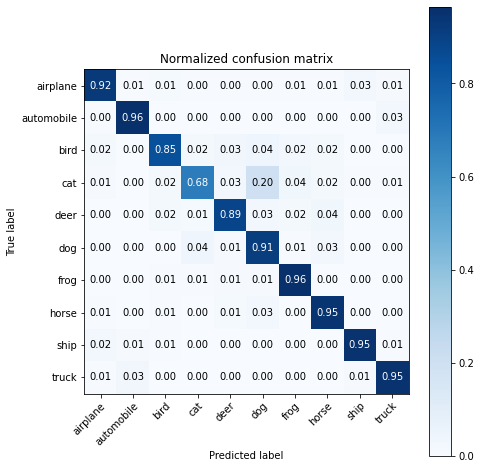

In [17]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.show()